In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
with open('../AL - experiment/df_pickle/df_context.pkl', 'rb') as f:
    df_context = pickle.load(f)

In [3]:
with open('./question-context-20.pkl', 'rb') as f:
    df_20 = pickle.load(f)
df_20.reset_index(inplace=True)

In [4]:
from sentence_transformers import SentenceTransformer, util

In [5]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

In [6]:
df_20['question'].unique()

array(["What was the subject of Alan Turing's famous essay?",
       'How did Alan Turing suggest we approach the question of building intelligent machines?',
       'What did Alan Turing propose as an alternative to defining intelligence?',
       ...,
       'Who is credited with first using mixture models to analyze the length of crabs?',
       'When was the EM algorithm first named?',
       'What is the goal of density estimation and how is it relevant in practical applications?'],
      dtype=object)

In [7]:
# context_embeddings = {ctx: model.encode(ctx) for ctx in df_20['context'].unique()}
# question_embeddings = {q: model.encode(q) for q in df_20['question'].unique()}
# with open('./context_embeddings.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings))
# with open('./question_embeddings.pkl', 'wb') as f:
#     f.write(pickle.dumps(question_embeddings))
with open('./context_embeddings.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open('./question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())

In [8]:
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_20['context'].unique()
data = []

for i,row in df_20.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    #dft.loc[dft['context']==row['context'],'label'] = 1

    for ctx in df_20.loc[df_20['question'] == row['question'],'context']:
        # if int(dft.loc[dft['context']==ctx,'label']) == 1:
        #     print("AASASASSASAS")
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

3198

In [9]:
df

,context,question,label
0,How can we build intelligent machines? More t...,What was the subject of Alan Turing's famous e...,1
1,Machine learning is the implementation of Tur...,What was the subject of Alan Turing's famous e...,0
2,Data mining refers to the discovery of patter...,What was the subject of Alan Turing's famous e...,0
3,Artificial intelligence is the construction o...,What was the subject of Alan Turing's famous e...,0
4,Machine learning draws on a number of discipl...,What was the subject of Alan Turing's famous e...,0
...,...,...,...
506395,10.1.3 Cross-validation for quantifying genera...,What is the goal of density estimation and how...,0
506396,10.1.4 Cross-validation for model selection We...,What is the goal of density estimation and how...,0
506397,10.1.5 Two-layer cross-validation Let’s turn t...,What is the goal of density estimation and how...,0
506398,The Apriori algorithm is very efficient at ide...,What is the goal of density estimation and how...,0


# Models

In [ ]:
n_test_q = int(0.25*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

n_test_ctx = int(0.25*len(df['context'].unique()))
test_ctx = np.random.choice(df['context'].unique(), n_test_ctx, replace=False)

df_test = df.loc[df['question'].isin(test_q)].loc[df['context'].isin(test_ctx)]
df_test.reset_index(inplace=True, drop=True)
df_train = df.loc[~df['question'].isin(test_q)].loc[~df['context'].isin(test_ctx)]
df_train.reset_index(inplace=True, drop=True)

X_train = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train['context'].values, df_train['question'].values)])
y_train = np.array([i for i in df_train['label'].values])

### Neural Network

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [38]:
neural_net = Sequential()
neural_net.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net.add(Dense(384, activation='relu'))
#neural_net.add(Dropout(rate=0.2))
#neural_net.add(Dense(256, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))

neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
import tensorflow as tf
class BatchBalancerSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x_p = x_set[y_set==1]
        self.x_n = x_set[y_set==0]
        self.batch_size = batch_size
        self.batch_size_n = batch_size//2

    def __len__(self):
        #For each n y=0 we will oversample with n y=1
        return int(np.ceil(len(self.x_n)*2 / self.batch_size))

    def __getitem__(self, idx):
        low = idx * self.batch_size_n
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size_n, len(self.x_n))
        batch_x = self.x_n[low:high]
        n_neg = len(batch_x)
        batch_y = [0]*n_neg
        
        x_p_idx = np.random.choice(len(self.x_p), n_neg, replace=False)
        batch_x = np.concatenate((batch_x, self.x_p[x_p_idx]))
        batch_y = np.append(batch_y, [1]*n_neg)

        return batch_x, batch_y

In [16]:
history = neural_net.fit(BatchBalancerSequence(X_train, y_train, 32), epochs=5)

Epoch 1/5
17692/17692 [==============================] - 146s 8ms/step - loss: 0.0896 - accuracy: 0.9669
Epoch 2/5
17692/17692 [==============================] - 136s 8ms/step - loss: 0.0239 - accuracy: 0.9932
Epoch 3/5
17692/17692 [==============================] - 145s 8ms/step - loss: 0.0149 - accuracy: 0.9960
Epoch 4/5
17692/17692 [==============================] - 136s 8ms/step - loss: 0.0103 - accuracy: 0.9972
Epoch 5/5
17692/17692 [==============================] - 127s 7ms/step - loss: 0.0083 - accuracy: 0.9976


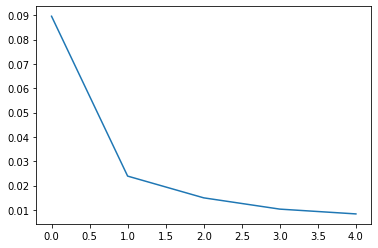

In [28]:
plt.plot(history.history['loss'])

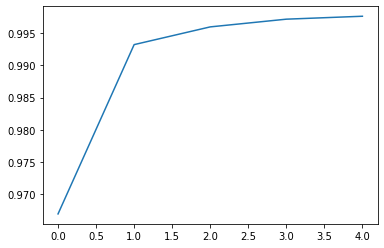

In [29]:
plt.plot(history.history['accuracy'])

## Matrix model

In [217]:
import tensorflow as tf
from tqdm import tqdm

def calculate_dot_product(a, W, b):
    return tf.reduce_sum(a * W * b, axis=-1)

learning_rate = 0.1

W = tf.Variable(np.ones(768))

len_train = X_train.shape[0]

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


batch_size = 64
itt = int(np.ceil(len_train/batch_size))

n_epochs = 5

with tqdm(total=itt*n_epochs) as pbar:
    for _ in range(n_epochs):
        for i in range(1,itt+1):
            low = (i-1)*batch_size
            high = min(i*batch_size, len_train)
            a = X_train[low:high,:1536//2]
            b = X_train[low:high,1536//2:]
            a = a/np.linalg.norm(a)
            b = b/np.linalg.norm(b)

            y = y_train[i-1]
            
            with tf.GradientTape() as tape:
                tape.watch(W)  # Watch the variable W for gradient computation
                dot_product = calculate_dot_product(a, W, b)
                loss = tf.square(dot_product - y)

                gradients = tape.gradient(loss, W)
                optimizer.apply_gradients([(gradients, W)])  # Update W using optimizer#W = W.assign_sub(learning_rate * gradients)
            pbar.update(1)

  1%|          | 153/22260 [00:01<03:35, 102.70it/s]

## Test models

In [98]:
X_test = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test['context'].values, df_test['question'].values)])
y_test = np.array([i for i in df_test['label'].values])

In [18]:
y_nn_preds = neural_net.predict(X_test)

989/989 [==============================] - 4s 4ms/step


In [99]:
y_cosine_preds = [np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(X_test[:,:1536//2], X_test[:,1536//2:])]

In [214]:
W = np.diag(np.array(W))
y_matrix_preds = [(a/np.linalg.norm(a))@W@(b/np.linalg.norm(b)) for a,b in zip(X_test[:,:1536//2], X_test[:,1536//2:])]

In [102]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

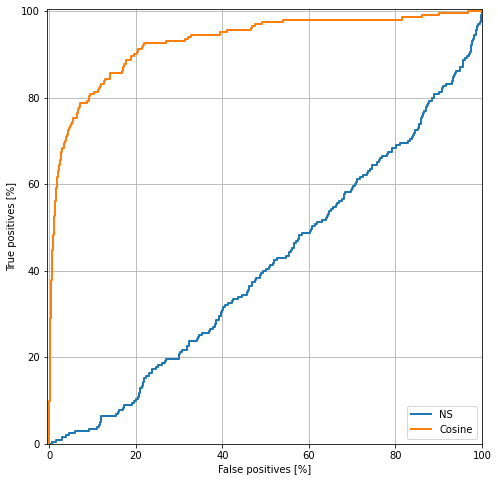

In [215]:
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_nn_preds)
plot_roc("Matrix", y_test, y_matrix_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

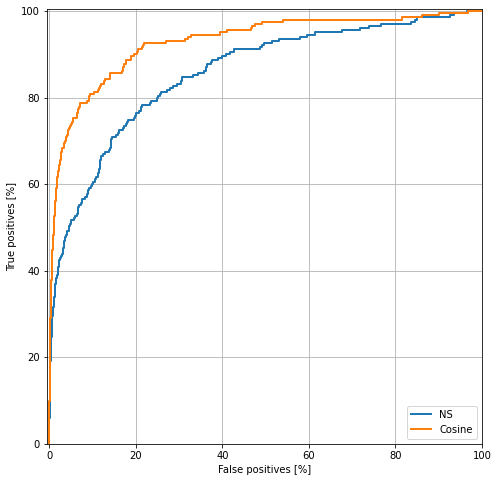

In [113]:
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

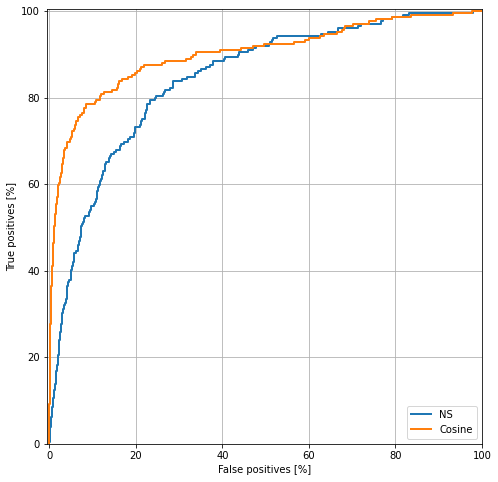

In [21]:
#plot_roc("Train", train_labels, train_predictions_baseline, color=colors[0])
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_preds.flatten())
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

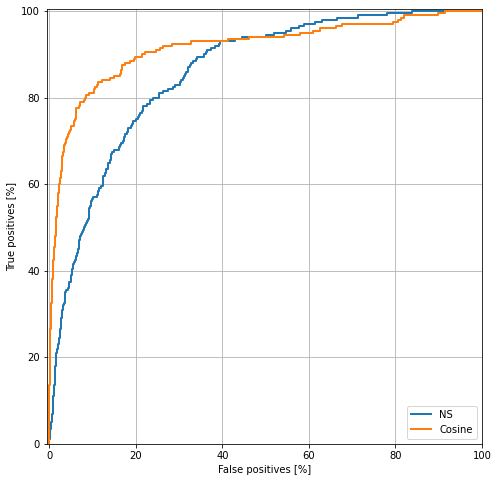

In [71]:
#plot_roc("Train", train_labels, train_predictions_baseline, color=colors[0])
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_preds.flatten())
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

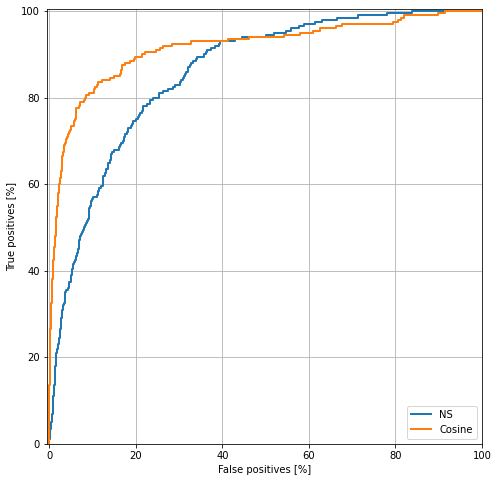

In [62]:
#plot_roc("Train", train_labels, train_predictions_baseline, color=colors[0])
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_preds.flatten())
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

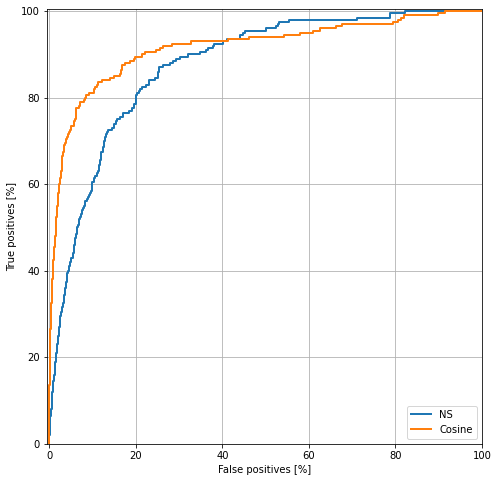

In [59]:
#plot_roc("Train", train_labels, train_predictions_baseline, color=colors[0])
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_preds.flatten())
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')